In [1]:
import torch
import numpy as np
import pandas as pd
import torchaudio
import noisereduce as nr
from sklearn.metrics import roc_curve, auc
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from torch.utils.data import random_split, DataLoader
from sklearn.model_selection import train_test_split



from customDatasets.audioDataset import AudioDataset

/home/francesco/miniconda3/envs/asi/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# free gpu
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [3]:
#Load training and test dataset

def set_seed(seed = 42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

data_path = "./data/train/"
data_path_test = "./data/test/"


meta_train_df = pd.read_csv("./data/train.csv")
meta_test_df = pd.read_csv("./data/test.csv")

train_df = meta_train_df[['filename', 'is_normal', 'machine_id']]
range_train, range_test = train_test_split(range(len(train_df)), test_size=0.2, train_size=0.8, random_state=None, shuffle=True, stratify=meta_train_df['machine_id'])

val_df = train_df.iloc[range_test].reset_index(drop=True)

train_df = train_df.iloc[range_train].reset_index(drop=True)

test_df = meta_test_df[['filename', 'is_normal', 'machine_id']]

train_audios = []
val_audios = []
test_audios = []
test_labels = []


for idx in range(len(train_df)):
    audio_file = data_path + train_df.loc[idx, 'filename']
    aud, sr = torchaudio.load(audio_file) 
    train_audios.append(aud)

for idx in range(len(val_df)):
    audio_file = data_path + val_df.loc[idx, 'filename']
    aud, sr = torchaudio.load(audio_file)
    val_audios.append(aud)

for idx in range(len(test_df)):
    audio_file = data_path_test + test_df.loc[idx, 'filename']
    aud, sr = torchaudio.load(audio_file) 
    test_audios.append(aud)
    test_labels.append(test_df.loc[idx, 'is_normal'])

In [4]:
import librosa
import numpy as np
import scipy

def extract_mfccs(y, n_mfcc=13, sr=16000, hop_length=256, n_fft=2048, denoise=False):
    
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)

    # Compute Delta and Delta-Delta (Acceleration) Coefficients
    #delta_mfccs = librosa.feature.delta(mfccs)
    #delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # Compute mean, std, skewness, and kurtosis for MFCCs
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    #mfccs_skew = scipy.stats.skew(mfccs, axis=1)
    #mfccs_kurt = scipy.stats.kurtosis(mfccs, axis=1)
    
    # Compute mean and std for Delta and Delta-Delta MFCCs
    #delta_mfccs_mean = np.mean(delta_mfccs, axis=1)
    #delta_mfccs_std = np.std(delta_mfccs, axis=1)
    #delta2_mfccs_mean = np.mean(delta2_mfccs, axis=1)
    #delta2_mfccs_std = np.std(delta2_mfccs, axis=1)
    
    # Extract other spectral features
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    
    # Compute mean and std for spectral features
    spectral_centroid_mean = np.mean(spectral_centroid)
    spectral_centroid_std = np.std(spectral_centroid)
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)
    spectral_bandwidth_std = np.std(spectral_bandwidth)
    spectral_contrast_mean = np.mean(spectral_contrast, axis=1)
    spectral_contrast_std = np.std(spectral_contrast, axis=1)
    spectral_rolloff_mean = np.mean(spectral_rolloff)
    spectral_rolloff_std = np.std(spectral_rolloff)
    
    # Extract temporal features
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    rms = librosa.feature.rms(y=y)
    
    # Compute mean and std for temporal features
    zero_crossing_rate_mean = np.mean(zero_crossing_rate)
    zero_crossing_rate_std = np.std(zero_crossing_rate)
    rms_mean = np.mean(rms)
    rms_std = np.std(rms)

    # Concatenate all features into a single feature vector
    feature_vector = np.concatenate([
        mfccs_mean, mfccs_std,
        #delta_mfccs_mean, delta_mfccs_std,
        #delta2_mfccs_mean, delta2_mfccs_std,
        [spectral_centroid_mean, spectral_centroid_std],
        [spectral_bandwidth_mean, spectral_bandwidth_std],
        spectral_contrast_mean, spectral_contrast_std,
        [spectral_rolloff_mean, spectral_rolloff_std],
        [zero_crossing_rate_mean, zero_crossing_rate_std],
        [rms_mean, rms_std]
    ])

    return feature_vector

In [50]:
generate_noisy = False
if generate_noisy:
    #generate a noisy dataset with different noise from test set, in order to simulate anomalies
    noisy_audios = []
    noisy_labels = []
    noisy_dataset = []
    for idx in range(len(train_audios)):
        audio = train_audios[idx]
        #Add gaussian, salt and pepper, poisson, and uniform noise each one for a quarter of the dataset
        if idx % 4 == 0:
            noise = np.random.normal(0, 0.5, audio.shape)
        elif idx % 4 == 1:
            noise = np.random.uniform(-1, 1, audio.shape)
        elif idx % 4 == 2:
            noise = np.random.poisson(0.5, audio.shape)
        else:
            noise = np.random.binomial(1, 0.5, audio.shape)
        noisy_audios.append(audio + noise)
        noisy_audios[idx] = nr.reduce_noise(y=noisy_audios[idx].squeeze(), sr=16000)
        features = extract_mfccs(np.array(noisy_audios[idx]))
        noisy_dataset.append(features)

    noisy_dataset = np.array(noisy_dataset)
    print(noisy_dataset.shape)


(1896, 102)


In [5]:
#Denoise audio
denoise=True

if denoise:
    for idx in range(len(train_audios)):
        features = nr.reduce_noise(y=train_audios[idx].squeeze(0), sr=16000)
        train_audios[idx] = features

    for idx in range(len(val_audios)):
        features = nr.reduce_noise(y=val_audios[idx].squeeze(0), sr=16000)
        val_audios[idx] = features

    for idx in range(len(test_audios)):
        features = nr.reduce_noise(y=test_audios[idx].squeeze(0), sr=16000)
        test_audios[idx] = features

In [6]:
audio = train_audios[0]
mfccs = librosa.feature.mfcc(y=audio, sr=16000, n_mfcc=13, hop_length=256, n_fft=2048)
print(mfccs.shape)

(13, 626)


In [7]:
mfcc = True
if mfcc:

    train_dataset = []
    val_dataset = []
    test_dataset = []

    for idx in range(len(train_audios)):
        features = extract_mfccs(np.array(train_audios[idx].squeeze()))
        train_dataset.append(features)

    for idx in range(len(val_audios)):
        features = extract_mfccs(np.array(val_audios[idx].squeeze()))
        val_dataset.append(features)

    for idx in range(len(test_audios)):
        features = extract_mfccs(np.array(test_audios[idx].squeeze()))
        test_dataset.append(features)

In [8]:
from sklearn.preprocessing import StandardScaler
train_dataset = np.array(train_dataset)
val_dataset = np.array(val_dataset)
test_dataset = np.array(test_dataset)
test_labels = np.array(test_labels)

#Normalize data
scaler = StandardScaler()
scaler.fit(train_dataset)
train_dataset = scaler.transform(train_dataset)
val_dataset = scaler.transform(val_dataset)
test_dataset = scaler.transform(test_dataset)

print(train_dataset.shape)
print(val_dataset.shape)
print(test_dataset.shape)

print(train_dataset[0])
print(val_dataset[0])
print(test_dataset[0])

(1896, 102)
(474, 102)
(1101, 102)
[ 0.10708118 -0.00899978 -0.03490146 -0.69463972  1.17080716  0.3049772
  1.45234631  1.05390032 -1.216634   -0.12026121  2.03574976  1.54163665
 -0.42813398 -1.61974239 -0.69429301 -1.19524239 -0.06987364 -1.13814468
 -0.75239083 -0.04352319  0.25132991 -1.40166152 -0.00812103 -0.47617895
 -0.76874194 -1.04425724  0.54554889  0.47332295 -0.0618542  -0.987425
  0.03258596  0.2971221  -0.26547306 -0.7920805  -0.35095489  0.93033505
 -0.7119058   1.18075027 -0.9701647  -0.82708744 -0.28256751 -0.6004425
  0.71937917 -0.93704363 -0.42960702 -0.05483457 -0.82654235 -1.32303924
 -0.16425064  0.42438782 -0.85650047 -0.95786364  0.52662927  0.51305729
 -1.60344808 -0.90760978 -0.4408833  -0.39504612  0.07789771  0.2336751
 -0.57747947  0.13484769 -2.61702071 -0.13058815  0.04814556 -0.58902143
 -0.09801207 -0.44391788  0.7779334  -0.9282262  -0.92135336 -0.39709247
 -1.08512855 -0.38303795  0.14611687  0.91968566 -0.41203944 -0.57548914
  0.05396511 -0.57123

In [9]:
pca = PCA(n_components=train_dataset.shape[1])
pca.fit(train_dataset)

PCA(n_components=102)

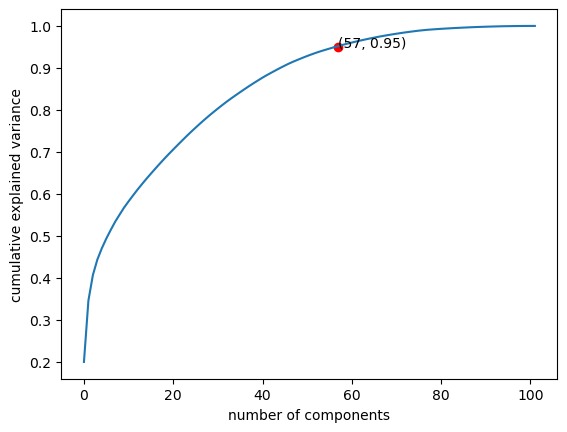

In [10]:
from matplotlib import pyplot as plt
#plot number of features vs explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95)
plt.scatter(n_components, 0.95, color='r')
plt.text(n_components, 0.95, '({}, {})'.format(n_components, 0.95), color='black')

plt.show()

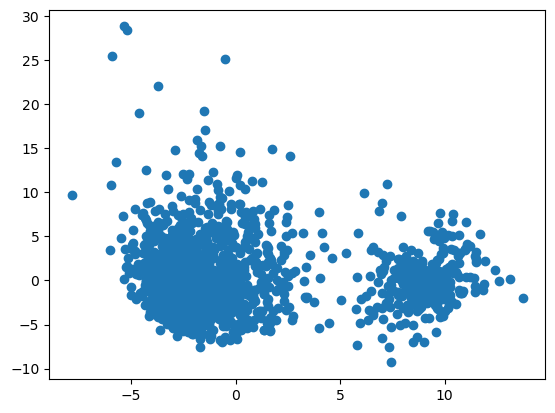

In [11]:
pca = PCA(n_components=10)
pca.fit(train_dataset)
DTR = pca.transform(train_dataset)
plt.scatter(DTR[:, 0], DTR[:, 1])
plt.show()

In [12]:
use_pca = False
pca = PCA(n_components=10)
pca.fit(train_dataset)
if use_pca:
    DTR = pca.transform(train_dataset)
    DEV = pca.transform(val_dataset)
    DTE = pca.transform(test_dataset)
else:
    DTR = train_dataset
    DEV = val_dataset
    DTE = test_dataset

test_mode = False

if test_mode:
    DTR = np.concatenate([DTR, DEV], axis=0)
    print(DTR.shape)

In [28]:
experiments = True
best_roc = 0
best_model = ""
best_val_ll = -np.inf
best_model_ll = ""
val_likelihoods = {'full' : [], 'tied' : [], 'diag' : []}
train_likelihoods = {'full' : [], 'tied' : [], 'diag' : []}
for covariance_type in ['full', 'tied', 'diag']:
    for n_components in range(1, 17):
        scores = []
        gmm = GaussianMixture(n_components=n_components, n_init=10, max_iter=1000, covariance_type=covariance_type)
        gmm.fit(DTR)
        scores = -gmm.score_samples(DTE)
        fpr, tpr, _ = roc_curve(test_labels, scores, pos_label=0)
        roc_auc = auc(fpr, tpr)
        if not test_mode:
            val_likelihood = gmm.score(DEV)
            val_likelihoods[covariance_type].append(val_likelihood)
        train_likelihood = gmm.score(DTR)
        train_likelihoods[covariance_type].append(train_likelihood)
        if val_likelihood > best_val_ll:
            best_val_ll = val_likelihood
            best_model_ll = f'{covariance_type}, {n_components}, AUC: {roc_auc}, Val Likelihood: {val_likelihood}, Train Likelihhod: {train_likelihood}'
        if roc_auc > best_roc:
            best_roc = roc_auc
            best_model = f'{covariance_type}, {n_components}, AUC: {roc_auc}, Val Likelihood: {val_likelihood}, Train Likelihood: {train_likelihood}'
        print(f'{covariance_type}, {n_components}, AUC: {roc_auc}, Val Likelihood: {val_likelihood}, Train Likelihood: {train_likelihood}')
print("Best model:"+str(best_model))
print("Best model ll:"+str(best_model_ll))



full, 1, AUC: 0.9160091552226384, Val Likelihood: -90.50028556765562, Train Likelihood: -84.97062884236361
full, 2, AUC: 0.9296795672076571, Val Likelihood: -87.67264998217667, Train Likelihood: -76.82888816017028
full, 3, AUC: 0.9351019558884728, Val Likelihood: -84.88544309699948, Train Likelihood: -70.2006420552801
full, 4, AUC: 0.9375156054931336, Val Likelihood: -84.61199267030639, Train Likelihood: -65.65479416774664
full, 5, AUC: 0.936059092800666, Val Likelihood: -86.19352484802054, Train Likelihood: -60.93519494374862
full, 6, AUC: 0.9320724094881399, Val Likelihood: -88.39109624030897, Train Likelihood: -52.01253206106001
full, 7, AUC: 0.8424594257178526, Val Likelihood: -106.24540596393099, Train Likelihood: -48.561662696371485
full, 8, AUC: 0.7678610070744902, Val Likelihood: -116.98387062415885, Train Likelihood: -37.82130079234598
full, 9, AUC: 0.8013857677902623, Val Likelihood: -120.62568211177393, Train Likelihood: -26.80713301334499
full, 10, AUC: 0.7554099042863089, 

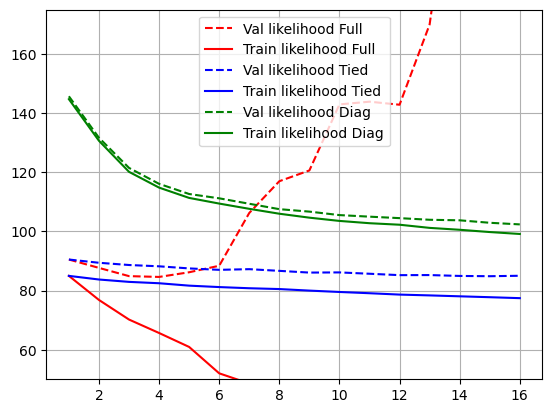

In [36]:
val_likelihoods['full'] = np.array(val_likelihoods['full'])
val_likelihoods['tied'] = np.array(val_likelihoods['tied'])
val_likelihoods['diag'] = np.array(val_likelihoods['diag'])
train_likelihoods['full'] = np.array(train_likelihoods['full'])
train_likelihoods['tied'] = np.array(train_likelihoods['tied'])
train_likelihoods['diag'] = np.array(train_likelihoods['diag'])

plt.plot(range(1, 17), -val_likelihoods['full'], label='Val likelihood Full', color='red', linestyle='dashed')
plt.plot(range(1, 17), -train_likelihoods['full'], label='Train likelihood Full', color='red')
plt.plot(range(1, 17), -val_likelihoods['tied'], label='Val likelihood Tied', color='blue', linestyle='dashed')
plt.plot(range(1, 17), -train_likelihoods['tied'], label='Train likelihood Tied', color='blue')
plt.plot(range(1, 17), -val_likelihoods['diag'], label='Val likelihood Diag', color='green', linestyle='dashed')
plt.plot(range(1, 17), -train_likelihoods['diag'], label='Train likelihood Diag', color='green')
#limit the y axis to 200
plt.ylim(50, 175)
plt.grid()
plt.legend()
plt.show()


In [51]:
gmm = GaussianMixture(n_components=4, n_init=10, max_iter=1000, covariance_type='full')
gmm.fit(DTR)
print(DTR.shape)
scores = -gmm.score_samples(np.concatenate([noisy_dataset, DTR]))
print(scores.shape)
fpr, tpr, _ = roc_curve(np.concatenate([np.zeros(noisy_dataset.shape[0]), np.ones(DTR.shape[0])]), scores, pos_label=0)
roc_auc = auc(fpr, tpr)
print(roc_auc)

(1896, 102)
(3792,)
1.0


2454781397.1463647
42.984368278657485


In [15]:
if not experiments:
    abs_best_roc = 0
    abs_best_model = ""
    for pca_components in [25, 26]:
        pca = PCA(n_components=pca_components)
        pca.fit(train_dataset)
        DTR = pca.transform(train_dataset)
        DTV = pca.transform(val_dataset)
        DTE = pca.transform(test_dataset)
        best_roc = 0
        best_model = ""
        best_val_ll = -np.inf
        best_model_ll = ""
        for covariance_type in ['full', 'tied', 'diag']:
            for n_components in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]:
                scores = []
                gmm = GaussianMixture(n_components=n_components)
                gmm.fit(DTR)
                scores = gmm.score_samples(DTE)
                print(scores.shape)
                fpr, tpr, _ = roc_curve(test_labels, scores, pos_label=1)
                roc_auc = auc(fpr, tpr)
                val_likelihood = gmm.score(DTV)
                if val_likelihood > best_val_ll:
                    best_val_ll = val_likelihood
                    best_model_ll = f'PCA:{pca_components}, {covariance_type}, {n_components}, AUC: {roc_auc}, Val Likelihood: {val_likelihood}'
                if roc_auc > best_roc:
                    best_roc = roc_auc
                    best_model = f'PCA:{pca_components}, {covariance_type}, {n_components}, AUC: {roc_auc}, Val Likelihood: {val_likelihood}'
                if roc_auc > abs_best_roc:
                    abs_best_roc = roc_auc
                    abs_best_model = f'PCA:{pca_components}, {covariance_type}, {n_components}, AUC: {roc_auc}, Val Likelihood: {val_likelihood}'
                print(f'PCA:{pca_components}, {covariance_type}, {n_components}, AUC: {roc_auc}, Val Likelihood: {val_likelihood}')
        print("Best model:"+str(best_model))
        print("Best model ll:"+str(best_model_ll))